In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

['400860-400861', '400861-403781', '400861-405376', '403781-400948', '403781-403047', '405376-401305']
{'400860-400861': ['400861-403781', '400861-405376'], '400861-403781': ['400860-400861', '403781-400948', '403781-403047'], '405376-401305': ['400861-405376'], '403781-403047': ['400861-403781'], '403781-400948': ['400861-403781'], '400861-405376': ['400860-400861', '405376-401305']}
cuda:1


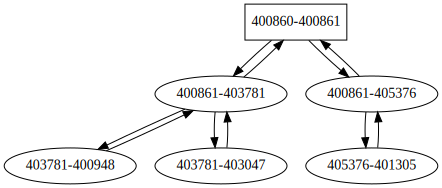

In [28]:
SROUTE, ADJ = read_graph('graphs/400860_n3.json')
graph = show_graph(SROUTE, ADJ)

DENSE = False
EPS = 120
LAG = 24 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
graph

In [37]:
dset = SpotHistory(SROUTE[:4], 'train', 32, lag=LAG, res=10).generator()
# evalset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10).generator()

2014-08-01 04:30:00 2014-08-02 03:30:00
2014-08-02 04:30:00 2014-08-03 03:50:00
2014-08-03 04:30:00 2014-08-04 03:50:00
2014-08-04 04:40:00 2014-08-05 03:20:00
2014-08-05 04:30:00 2014-08-06 03:30:00
2014-08-06 04:20:00 2014-08-07 03:40:00
2014-08-07 04:20:00 2014-08-08 03:40:00
2014-08-08 04:20:00 2014-08-09 03:40:00
2014-08-09 04:30:00 2014-08-10 03:30:00
2014-08-10 05:00:00 2014-08-11 03:50:00
2014-10-30 04:00:00 2014-08-12 03:10:00


IndexError: list index out of range

In [5]:
from models.temporal.RNN import *
from models.MPRNN import *

model = MPRNN(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE, 
    
    rnnmdl=RNN_MIN,
    mpnmdl=MP_DENSE,
    
    verbose=True).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.05)

model.clear_stats()
evf = lambda: evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

MPRNN
 [*] Defined over: 3 nodes
 [*] Contains    : 3 adjs
Eval loss: 82.081221           


In [8]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        bls.append(loss.item())
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            '(avg %.2f)' % (10 ** 2 * np.mean(bls)) if bii == len(dset) -1 else ''
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
    sch.step()

[1/120 : 320/320] - L1.35 (avg 1.19)      
Eval loss: 0.91694           
[2/120 : 320/320] - L1.16 (avg 0.93)      
Eval loss: 0.72143           
[3/120 : 320/320] - L0.92 (avg 0.80)      
Eval loss: 0.62160           
[4/120 : 320/320] - L1.46 (avg 0.71)      
Eval loss: 0.54382           
[5/120 : 320/320] - L1.57 (avg 0.65)      
Eval loss: 0.48832           
[6/120 : 320/320] - L0.60 (avg 0.59)      
Eval loss: 0.44077           
[7/120 : 320/320] - L0.39 (avg 0.54)      
Eval loss: 0.40629           
[8/120 : 320/320] - L0.54 (avg 0.50)      
Eval loss: 0.37311           
[9/120 : 320/320] - L0.33 (avg 0.46)      
Eval loss: 0.34831           
[10/120 : 320/320] - L0.33 (avg 0.43)      
Eval loss: 0.32743           
[11/120 : 320/320] - L0.33 (avg 0.41)      
Eval loss: 0.31043           
[12/120 : 320/320] - L0.37 (avg 0.39)      
Eval loss: 0.29652           
[13/120 : 320/320] - L0.25 (avg 0.37)      
Eval loss: 0.28652           
[14/120 : 320/320] - L0.22 (avg 0.35)      
Eva

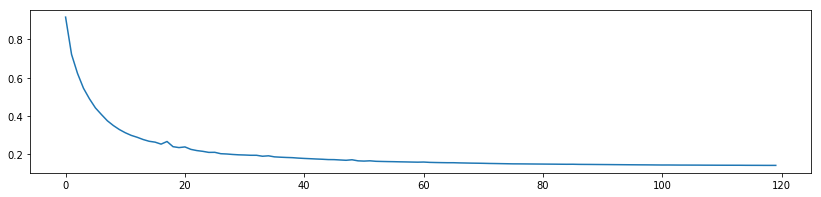

In [9]:
plt.figure(figsize=(14, 3))
plt.plot(eval_mse)
plt.show(); plt.close()

In [11]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=False)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

In [12]:
# torch.save(model.state_dict(), 'checkpoints/mpnn_n3.pth')
# torch.save(model, 'checkpoints/mpnn_n3_full.pth')
# model = torch.load('checkpoints/mpnn_n3_full.pth')

Eval segments: 18
Eval MSE: 0.1695


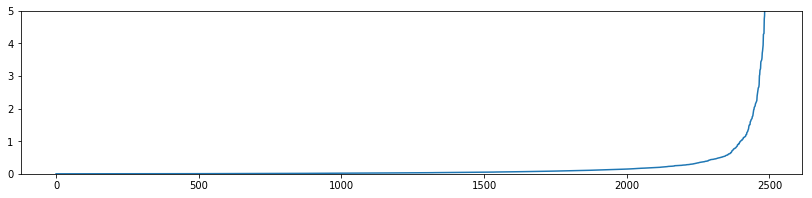

In [16]:
model.steps = len(SROUTE)
sqerr = eval_rnn(viewset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

Conditional Forecast


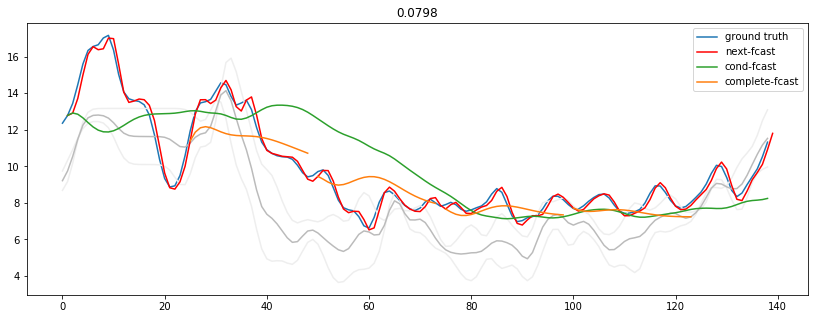

Conditional Forecast


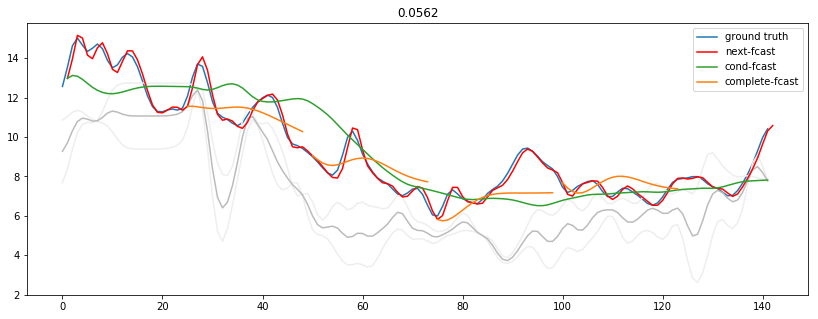

Conditional Forecast


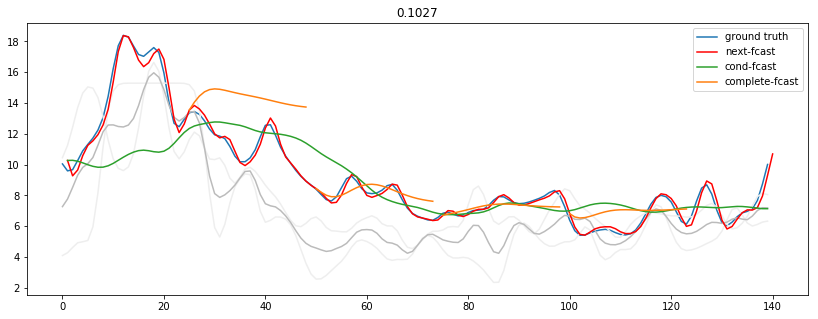

In [20]:
_ = eval_rnn(
    viewset[:3], model, 
    flag=LAG, fmax=24,
    xfmt=xfmt,
    plot=True)

In [23]:
for kk in model.state_dict().keys():
    print(kk)

rnns.0.inp.0.weight
rnns.0.inp.0.bias
rnns.0.out.0.weight
rnns.0.out.0.bias
rnns.0.rnn.weight_ih_l0
rnns.0.rnn.weight_hh_l0
rnns.0.rnn.bias_ih_l0
rnns.0.rnn.bias_hh_l0
rnns.1.inp.0.weight
rnns.1.inp.0.bias
rnns.1.out.0.weight
rnns.1.out.0.bias
rnns.1.rnn.weight_ih_l0
rnns.1.rnn.weight_hh_l0
rnns.1.rnn.bias_ih_l0
rnns.1.rnn.bias_hh_l0
rnns.2.inp.0.weight
rnns.2.inp.0.bias
rnns.2.out.0.weight
rnns.2.out.0.bias
rnns.2.rnn.weight_ih_l0
rnns.2.rnn.weight_hh_l0
rnns.2.rnn.bias_ih_l0
rnns.2.rnn.bias_hh_l0
mpns.0.msg_op.0.weight
mpns.0.msg_op.0.bias
mpns.0.msg_op.2.weight
mpns.0.msg_op.2.bias
mpns.0.upd_op.0.weight
mpns.0.upd_op.0.bias
mpns.0.upd_op.2.weight
mpns.0.upd_op.2.bias
mpns.1.msg_op.0.weight
mpns.1.msg_op.0.bias
mpns.1.msg_op.2.weight
mpns.1.msg_op.2.bias
mpns.1.upd_op.0.weight
mpns.1.upd_op.0.bias
mpns.1.upd_op.2.weight
mpns.1.upd_op.2.bias
mpns.2.msg_op.0.weight
mpns.2.msg_op.0.bias
mpns.2.msg_op.2.weight
mpns.2.msg_op.2.bias
mpns.2.upd_op.0.weight
mpns.2.upd_op.0.bias
mpns.2.upd_o

In [24]:
# torch.save(model, 'checkpoints/mpnn_thin_n2.pth')